In [1]:
# Imports
from astropy.visualization import make_lupton_rgb
import functools
import lsst.afw.image as afwImage
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.meas.base.measurementInvestigationLib as mil
import matplotlib.pyplot as plt
import modelling_research.dc2 as dc2
import modelling_research.meas_model as mrMeas
from modelling_research.plotting import plotjoint_running_percentiles
import modelling_research.tables as mrTables
import modelling_research.plot_matches as mrPlotMatches
import numpy as np
import matplotlib as mpl
import seaborn as sns

In [2]:
# Plot settings
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize'] = 10, 20
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})
sns.set_style('dark')

# Bands and colour balance
bands_weights = {'i': 1.0, 'r': 1.191, 'g': 2.249}

# Reference band for when we need to pick one
band_ref = 'r'
band_fit = 'griz'

In [3]:
# Load the original and Scarlet DC2 repo
name_scarlet = 'Scarlet'
name = name_scarlet
butler = Butler('/repo/dc2')
collection_prefix = 'u/dtaranu/DM-30920/scarlet'
has_multiprofit = False

In [4]:
# Read the central patch (DC2 is 7x7 vs HSC's 9x9 patches)
dataId = dict(tract=3828, skymap='DC2')
catexps_calibs = {}
exps_orig = {}
cat_refs = {}
wcs_refs = {}
catexps = {}
catexps_b = {}
exps_orig_b = {}
calibs_p = {}
patch_main = 24
collections = collection_prefix

for patch in (patch_main,) if has_multiprofit else range(49):
    print(f'Reading patch {patch}')
    calibs_b = {}
    catexps_b = {}
    dataId['patch'] = patch
    is_main = patch == patch_main
    if is_main:
        cat_refs[name] = butler.get(
            'deepCoadd_ref', **dataId,
            collections=f'{collection_prefix}mpf_{band_ref}' if has_multiprofit else collection_prefix
        )
    for band in bands_weights:
        if has_multiprofit:
            collections = f'{collection_prefix}mpf_{band}'
        cat = butler.get('deepCoadd_meas', **dataId, band=band, collections=collections)
        exp = butler.get('deepCoadd_calexp', **dataId, band=band, collections=collections)
        if is_main:
            exp.variance.array = 1./np.sqrt(exp.variance.array)
            exp_main = exp
        catexps_b[band] = mrMeas.CatExp(band=band,
                                        cat=cat,
                                        img=exp.image if is_main else None,
                                        siginv=exp.variance if is_main else None,
                                       )
        calibs_b[band] = exp.getPhotoCalib()
        # We don't need to keep these for the old deblender
        if is_main and (name == name_scarlet):
            exps_orig_b[band] = exp
        if band == band_ref:
            wcs_refs[name] = exp.getWcs()
    catexps_calibs[patch] = (catexps_b, calibs_b)
patch = patch_main
catexps[name], calibs = catexps_calibs[patch]
exps_orig[name] = exps_orig_b

Reading patch 0
Reading patch 1
Reading patch 2
Reading patch 3
Reading patch 4
Reading patch 5
Reading patch 6
Reading patch 7
Reading patch 8
Reading patch 9
Reading patch 10
Reading patch 11
Reading patch 12
Reading patch 13
Reading patch 14
Reading patch 15
Reading patch 16
Reading patch 17
Reading patch 18
Reading patch 19
Reading patch 20
Reading patch 21
Reading patch 22
Reading patch 23
Reading patch 24
Reading patch 25
Reading patch 26
Reading patch 27
Reading patch 28
Reading patch 29
Reading patch 30
Reading patch 31
Reading patch 32
Reading patch 33
Reading patch 34
Reading patch 35
Reading patch 36
Reading patch 37
Reading patch 38
Reading patch 39
Reading patch 40
Reading patch 41
Reading patch 42
Reading patch 43
Reading patch 44
Reading patch 45
Reading patch 46
Reading patch 47
Reading patch 48


In [5]:
# Load MultiProFit fits (if they exist, or calibrate cats otherwise)
band_ref = 'r'
name_nr = 'NR'
if has_multiprofit:
    # These structures are somewhat convoluted, sorry. Bear with it.
    reruns_mpf = {
        name_scarlet: [
            (name_nr, '/project/dtaranu/dc2_gen3/w_2021_24_multibandfit/calcats/'),
        ]
    }
    namepaths = {}
    for name_deblender, reruns_d in reruns_mpf.items():
        for name_rerun, path_rerun in reruns_d:
            namepaths[f'{name_deblender}_{name_rerun}'] = (name_deblender, path_rerun)

    cats_mpf = {
        name_mpf: mrTables.read_split_cat_fits(f'{namepath[1]}{band_fit}/mpf_dc2_griz_3828_{patch}_mag.fits')
        for name_mpf, namepath in namepaths.items()
    }
else:
    cats_calib = {}
    for p, (catexps_b, calibs_b) in catexps_calibs.items():
        cats_calib_b = {}
        for band, catexp in catexps_b.items():
            cats_calib_b[band] = calibs_b[band].calibrateCatalog(catexp.cat)
        cats_calib[p] = cats_calib_b
    cats_mpf = {f'{name_scarlet}_{name_nr}': cats_calib[patch][band_ref]}

In [6]:
# Define measurements (models)
name_full = f'{name_scarlet}_{name_nr}'
models_meas = {
    'Base PSF': mrMeas.Model('Base PSF', 'base_PsfFlux', 0),
    'CModel': mrMeas.Model('Stack CModel', 'modelfit_CModel', 2),
}
if has_multiprofit:
    models_meas['MPF Sersic']: mrMeas.Model('MPF Sersic', 'multiprofit_mg8serbpx', 1)
models_meas = {name_full: models_meas}

In [7]:
# Match against DC2
butler_ref = dc2.get_refcat(make=False)
if has_multiprofit:
    filters_single = ('g', 'r', 'i', 'z')
    filters_multi = ('griz',)
    band_multi = filters_multi[0]
    band_ref = 'r'
    get_path_cats = functools.partial(dc2.get_path_cats, patches_regex='*')
else:
    filters_single = ('g', 'r', 'i')
    def get_path_cats(prefix, band, tract):
        return [(p, cats_calib_b[band]) for p, cats_calib_b in cats_calib.items()]

    def func_patch(patch):
        return patch

kwargs_get = {'skymap': 'DC2', 'collections': f'{collection_prefix}mpf_{band_multi}' if has_multiprofit else collection_prefix}

if has_multiprofit:
    cats_dc2 = {
        name: dc2.match_refcat_dc2(
            butler_ref, match_afw=False,
            tracts={3828: (path, '2.2i'),}, butlers_dc2={'2.2i': butler},
            filters_single=filters_single, filters_multi=filters_multi, func_path=get_path_cats,
            kwargs_get={'skymap': 'DC2', 'collections': collections},
        )
        for name, (name_butler, path) in namepaths.items()
    }
else:
    cats_dc2 = {
        f'{name_scarlet}_{name_nr}': dc2.match_refcat_dc2(
            butler_ref, match_afw=False,
            tracts={3828: (None, '2.2i'),}, butlers_dc2={'2.2i': butler},
            filters_single=filters_single, filters_multi=(),
            func_path=get_path_cats, func_patch=func_patch,
            kwargs_get=kwargs_get,
        )
    }

/home/dtaranu/src/mine/modelling_research/dc2.py:60: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = Butler(refcat_path)
/home/dtaranu/src/mine/modelling_research/dc2.py:60: FutureWarning: Gen2 Butler has been deprecated (ImsimMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = Butler(refcat_path)


LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading Posix exposure registry from /project/dtaranu/dc2/ref_cats/gal_ref_cat
Loading tract 3828 band r
Loaded in 12.4s; loading 0 (1/49) and matching file=0; len(cat,truth)=12454,109327
Loaded in 12.9s; loading 1 (2/49) and matching file=1; len(cat,truth)=27282,217504
Loaded in 13.7s; loading 2 (3/49) and matching file=2; len(cat,truth)=41055,322293
Loaded in 30.1s; loading 3 (4/49) and matching file=3; len(cat,truth)=54898,427568
Loaded in 30.5s; loading 4 (5/49) and matching file=4; len(cat,truth)=68049,530909
Loaded in 21.8s; loading 5 (6/49) and matching file=5; len(cat,truth)=82298,633629
Loaded in 22.1s; loading 6 (7/49) and matching file=6; len(cat,truth)=93340,737342
Loaded in 21.5s; loading 7 (8/49) and matching file=7; len(cat,truth)=106943,842174
Loaded in 21.7s; loading 8 (9/49) and matching file=8; len(cat,truth)=124194,946436
Loaded in 21.6s; loading 9 (10/49) and matching file=9; len(cat,t

Loaded in 0.0s; loading 35 (36/49) file=35; len(cat,truth)=551291,5111088
Loaded in 0.0s; loading 36 (37/49) file=36; len(cat,truth)=568864,5111088
Loaded in 0.0s; loading 37 (38/49) file=37; len(cat,truth)=586475,5111088
Loaded in 0.0s; loading 38 (39/49) file=38; len(cat,truth)=603244,5111088
Loaded in 0.0s; loading 39 (40/49) file=39; len(cat,truth)=619394,5111088
Loaded in 0.0s; loading 40 (41/49) file=40; len(cat,truth)=635899,5111088
Loaded in 0.0s; loading 41 (42/49) file=41; len(cat,truth)=649647,5111088
Loaded in 0.0s; loading 42 (43/49) file=42; len(cat,truth)=662023,5111088
Loaded in 0.0s; loading 43 (44/49) file=43; len(cat,truth)=676522,5111088
Loaded in 0.0s; loading 44 (45/49) file=44; len(cat,truth)=691011,5111088
Loaded in 0.0s; loading 45 (46/49) file=45; len(cat,truth)=705044,5111088
Loaded in 0.0s; loading 46 (47/49) file=46; len(cat,truth)=718291,5111088
Loaded in 0.0s; loading 47 (48/49) file=47; len(cat,truth)=731741,5111088
Loaded in 0.0s; loading 48 (49/49) fil

N=0 sky object matches
Rematched 6881/5100291; 481753 originally and 474737 rematched already matched
N=0sky object matches after rematching
DC2 3828 Resolved g-band, Base PSF, N=85290


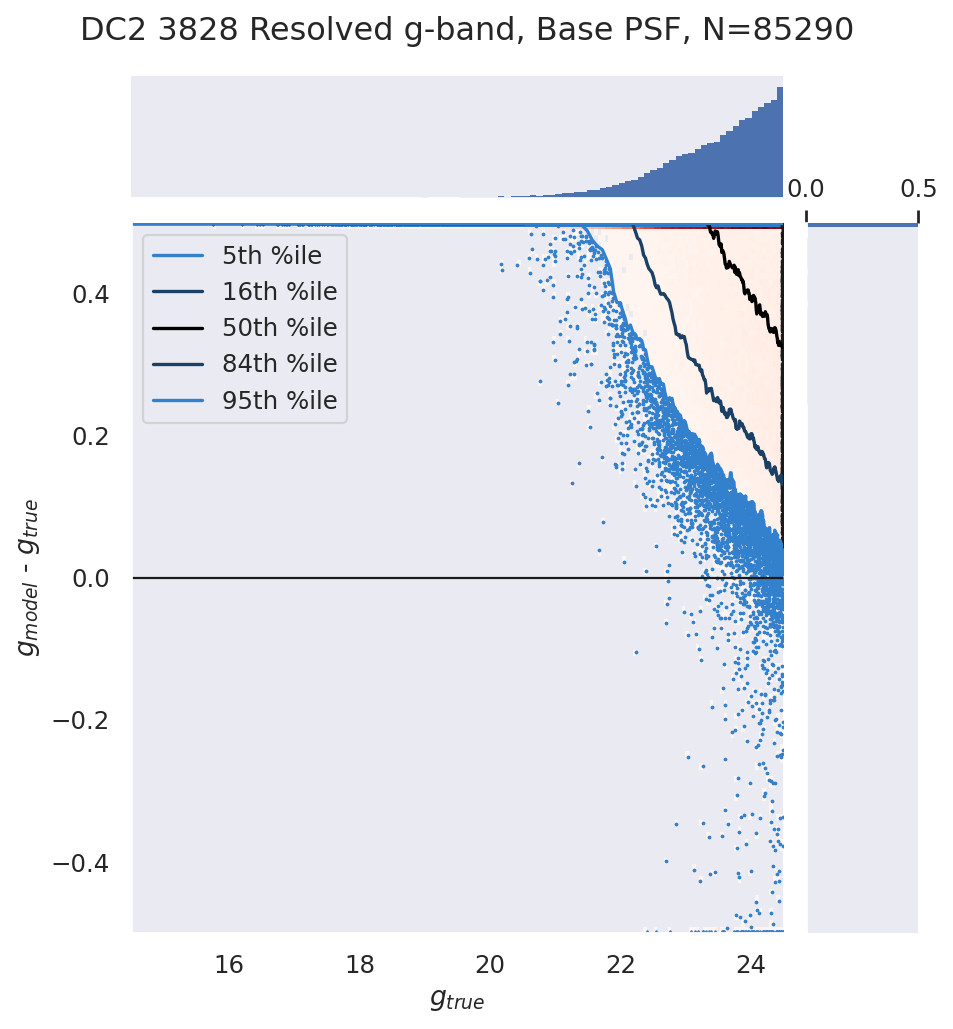

DC2 3828 Resolved r-band, Base PSF, N=130726


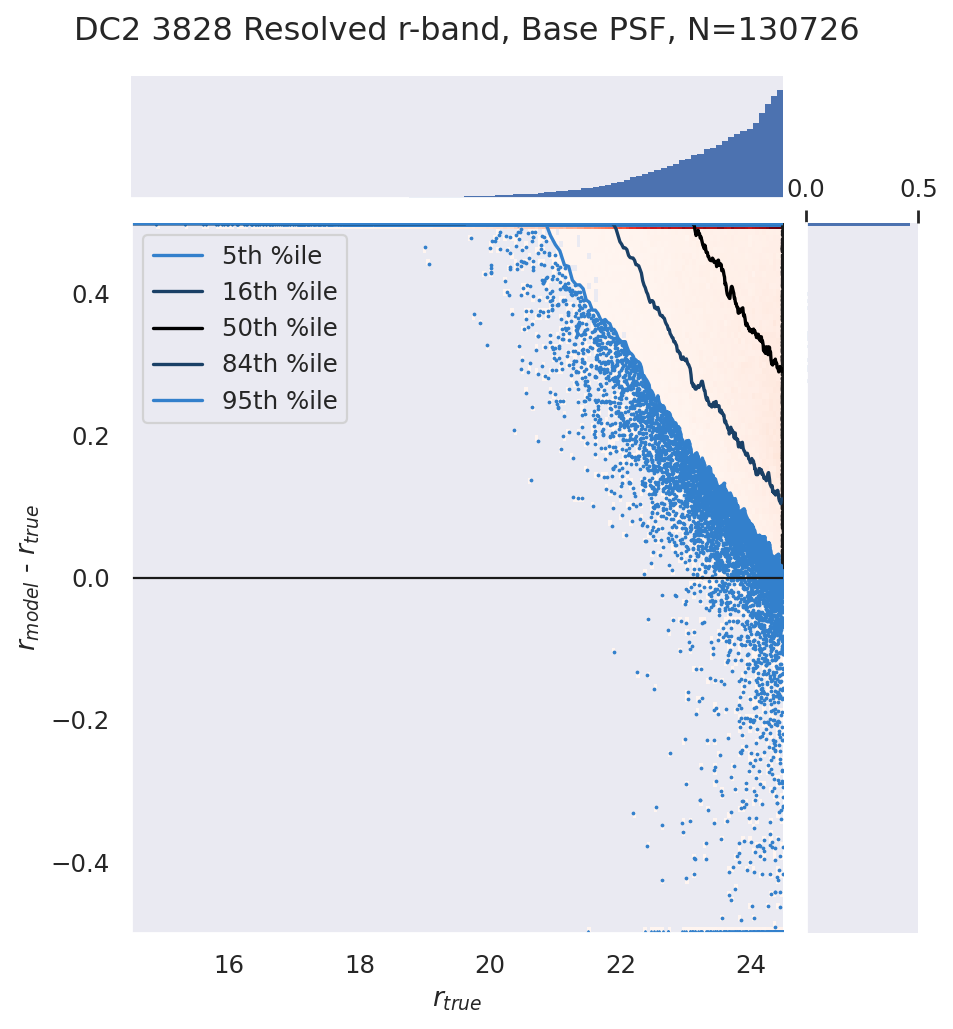

DC2 3828 Resolved i-band, Base PSF, N=185939


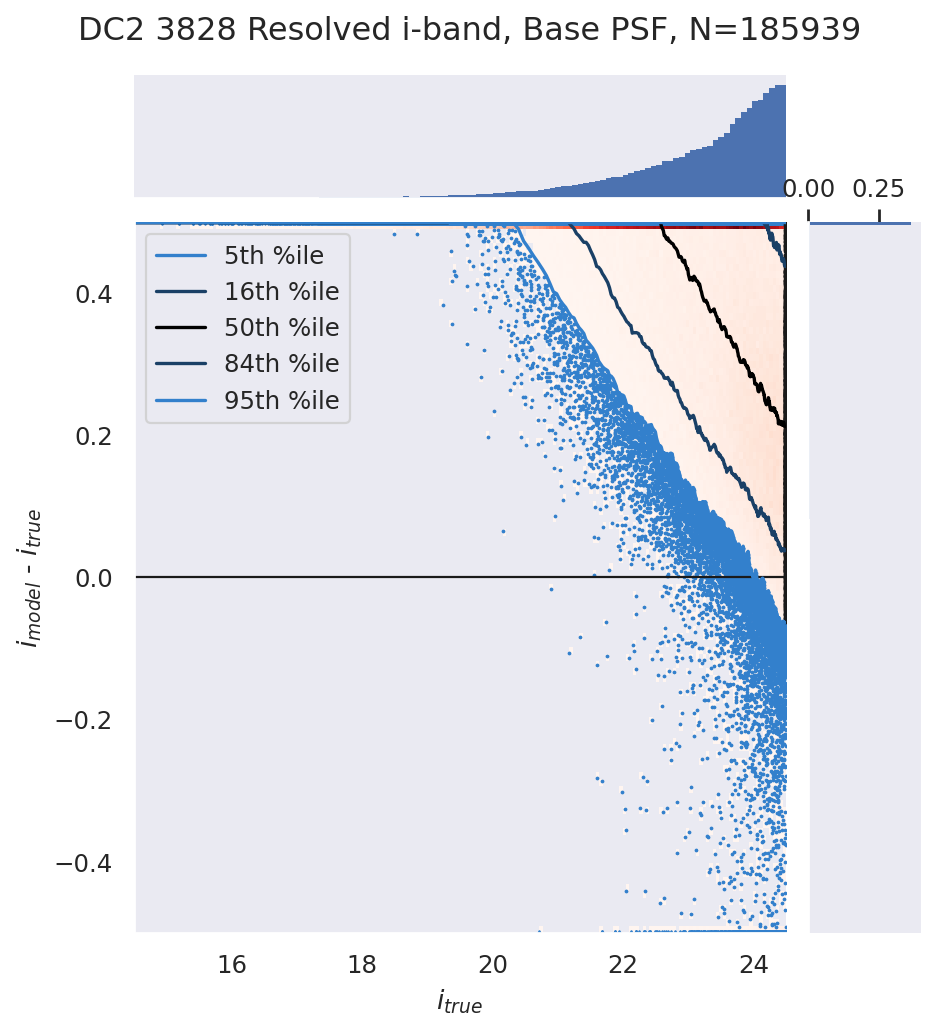

DC2 3828 Resolved g-r, Base PSF, N=130685


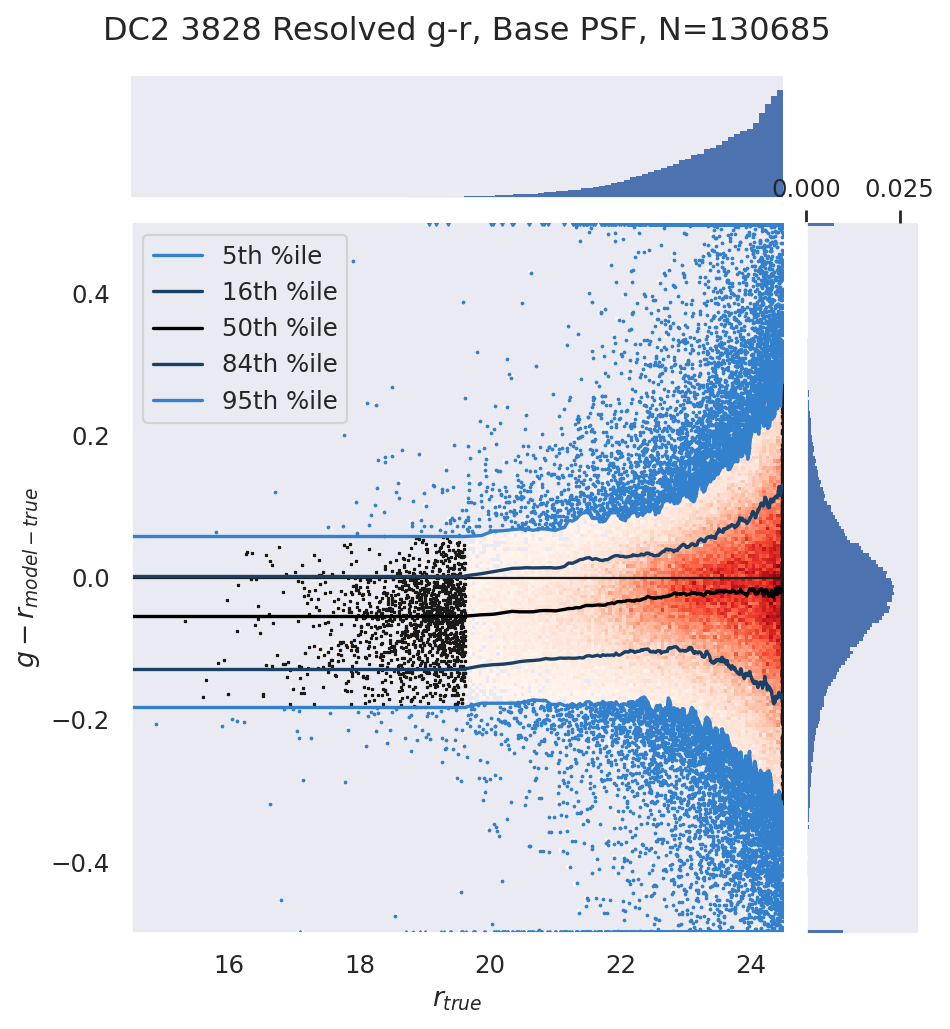

DC2 3828 Resolved r-i, Base PSF, N=130686


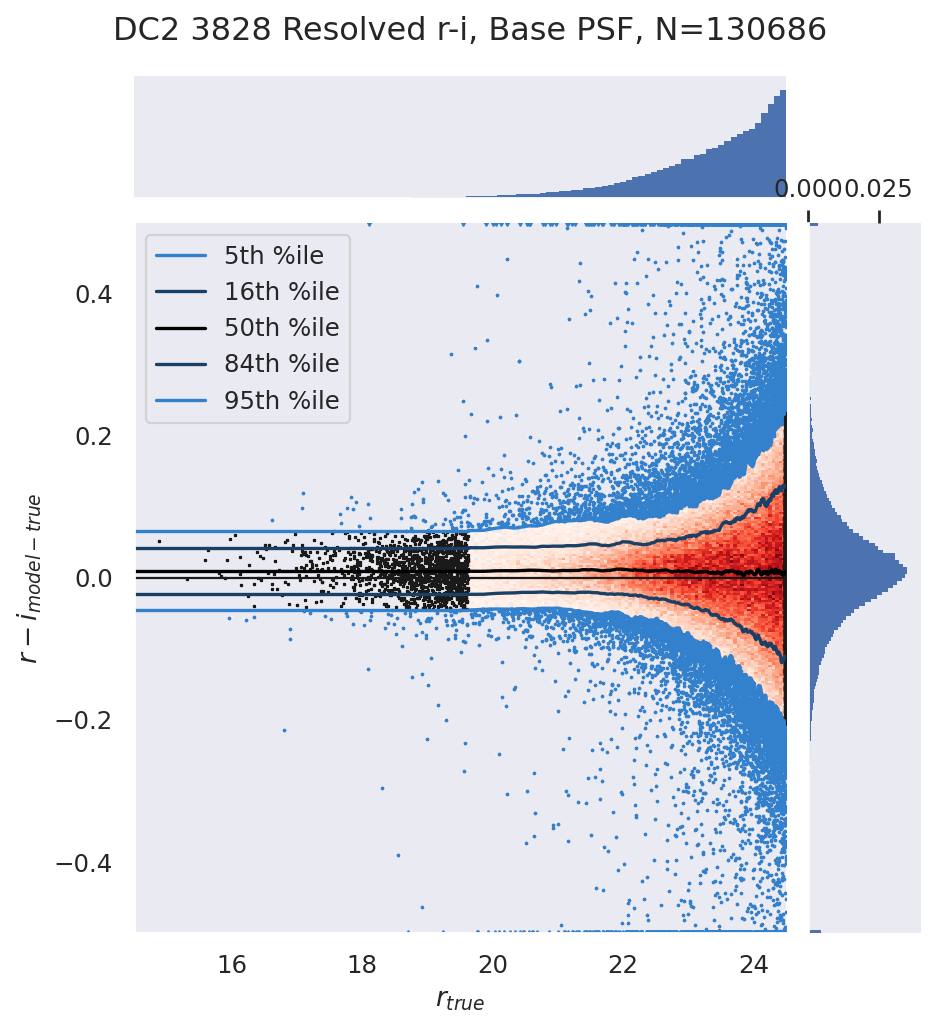

DC2 3828 Resolved g-band, CModel, N=84994


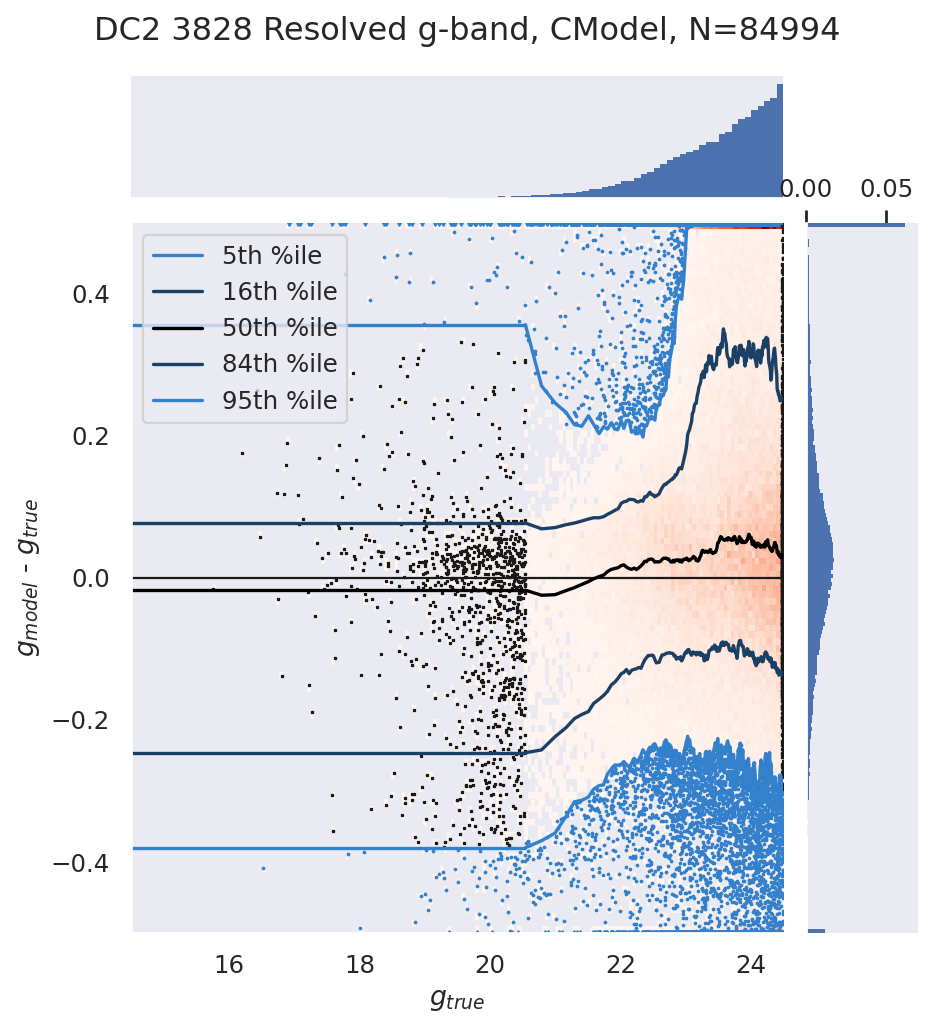

DC2 3828 Resolved r-band, CModel, N=130399


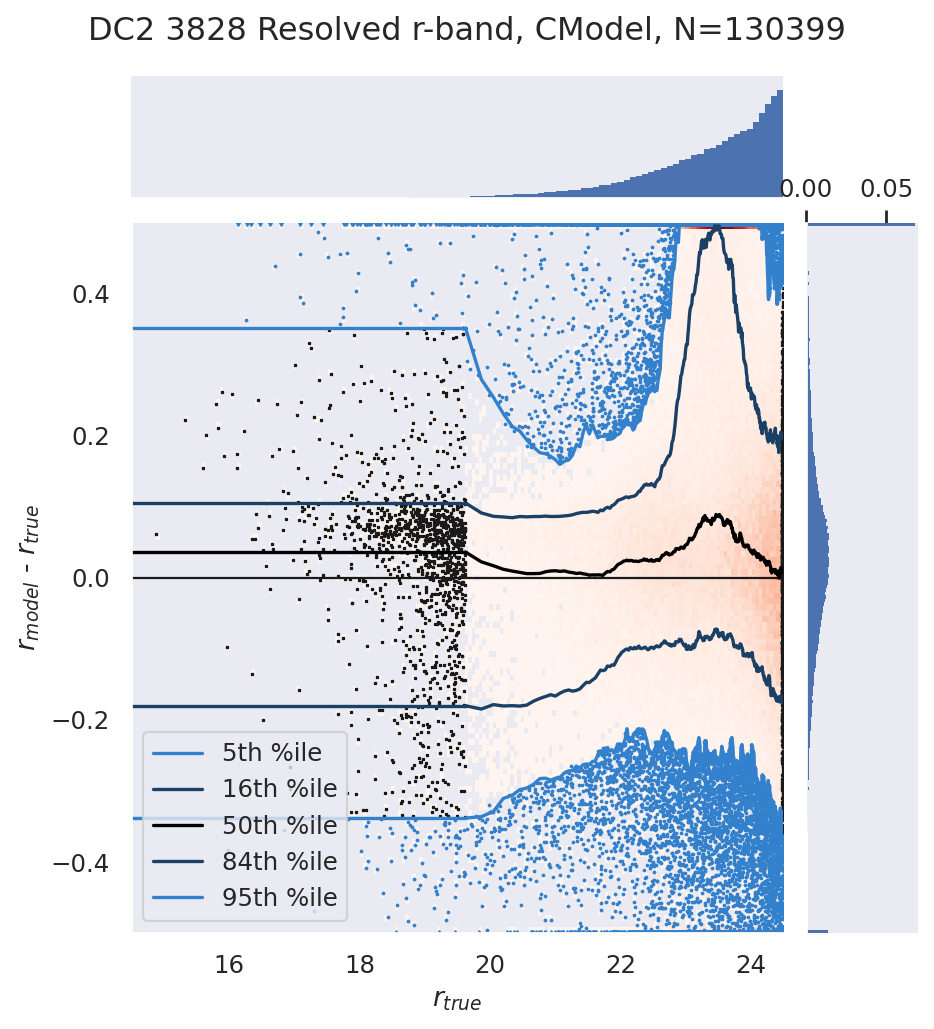

DC2 3828 Resolved i-band, CModel, N=185521


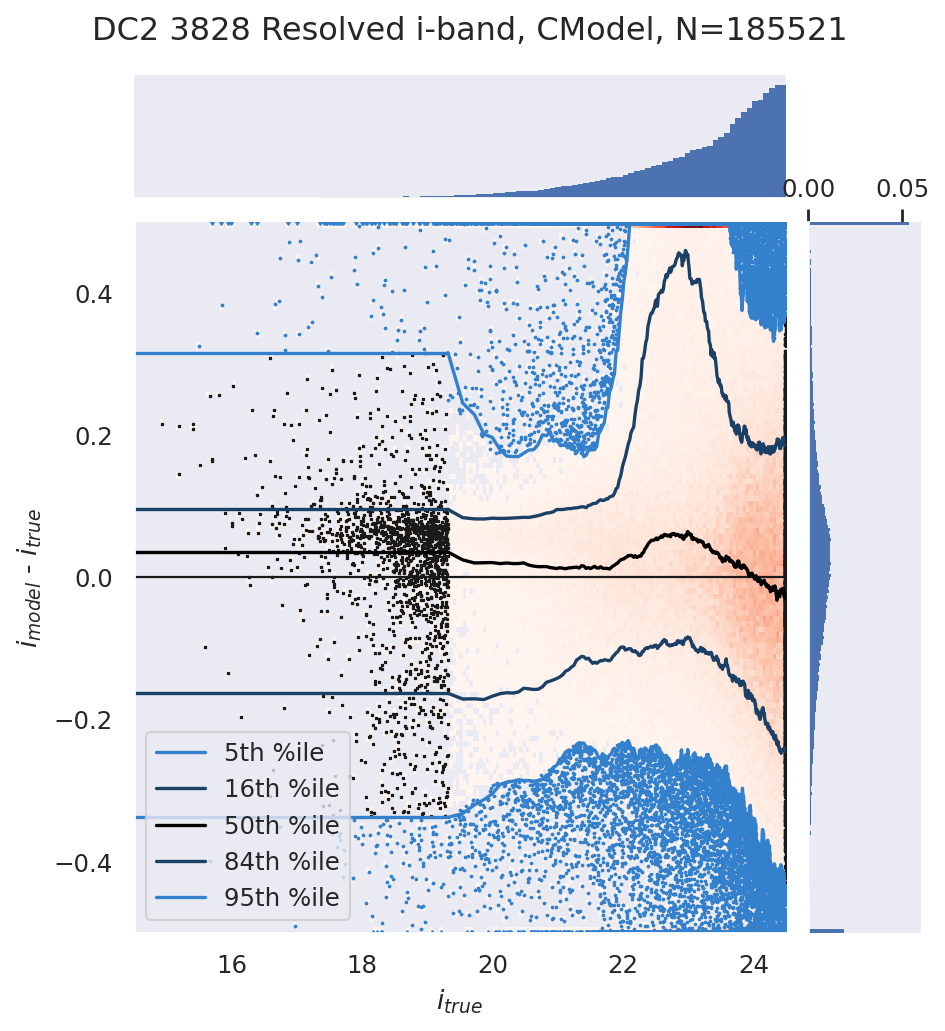

DC2 3828 Resolved g-r, CModel, N=130093


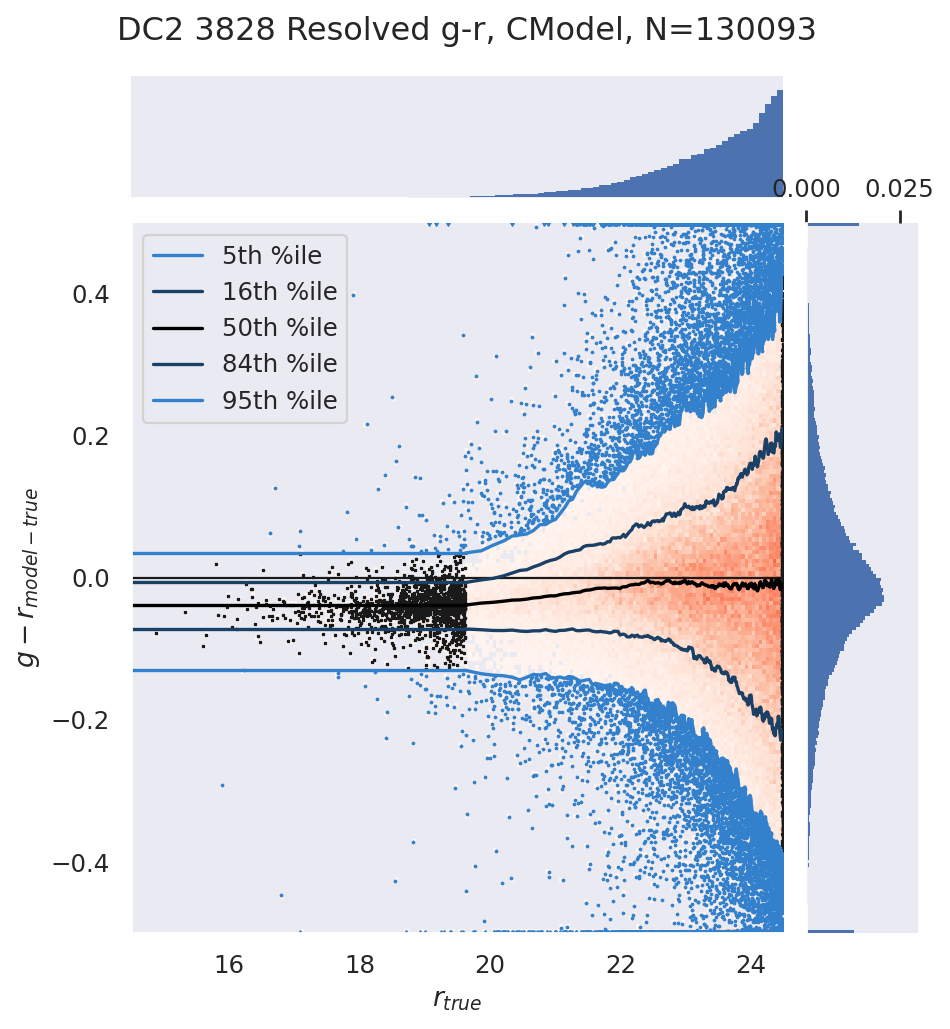

DC2 3828 Resolved r-i, CModel, N=130233


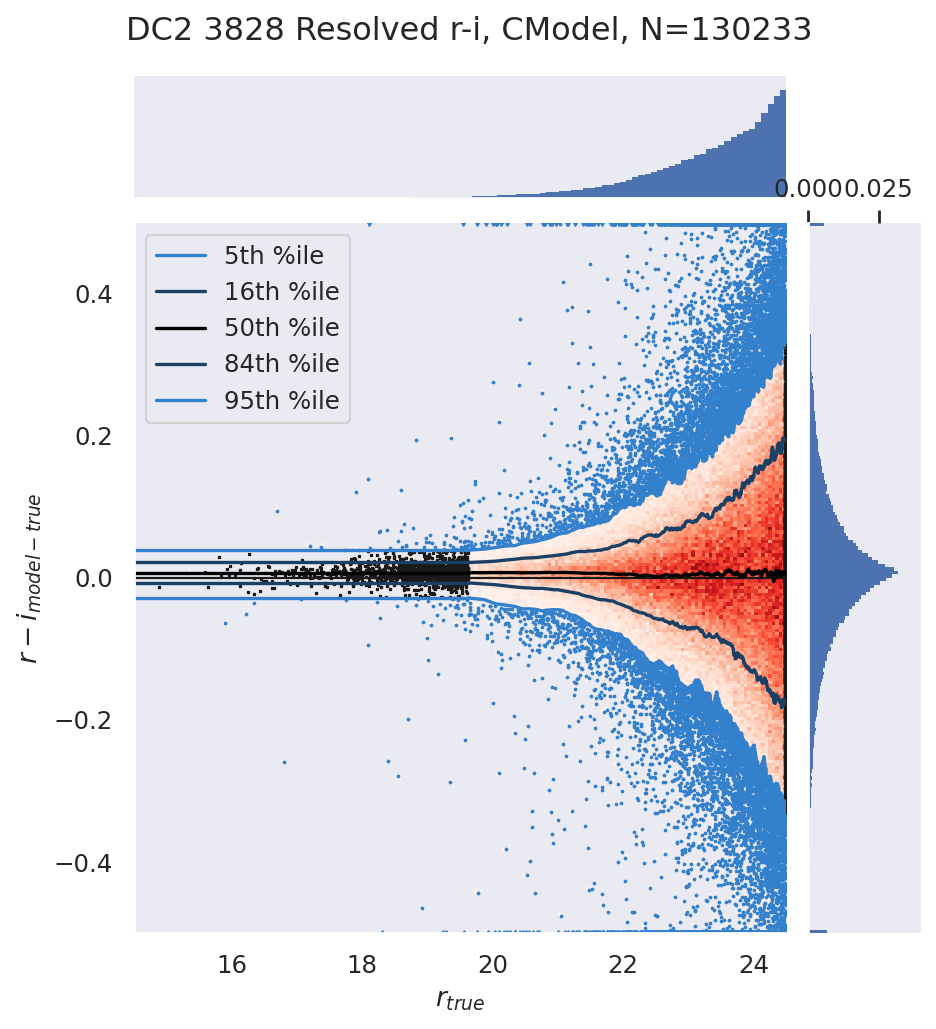

N=0 sky object matches
Rematched 137/10797; 9213 originally and 9214 rematched already matched
N=0sky object matches after rematching
DC2 3828 Unresolved g-band, Base PSF, N=9307


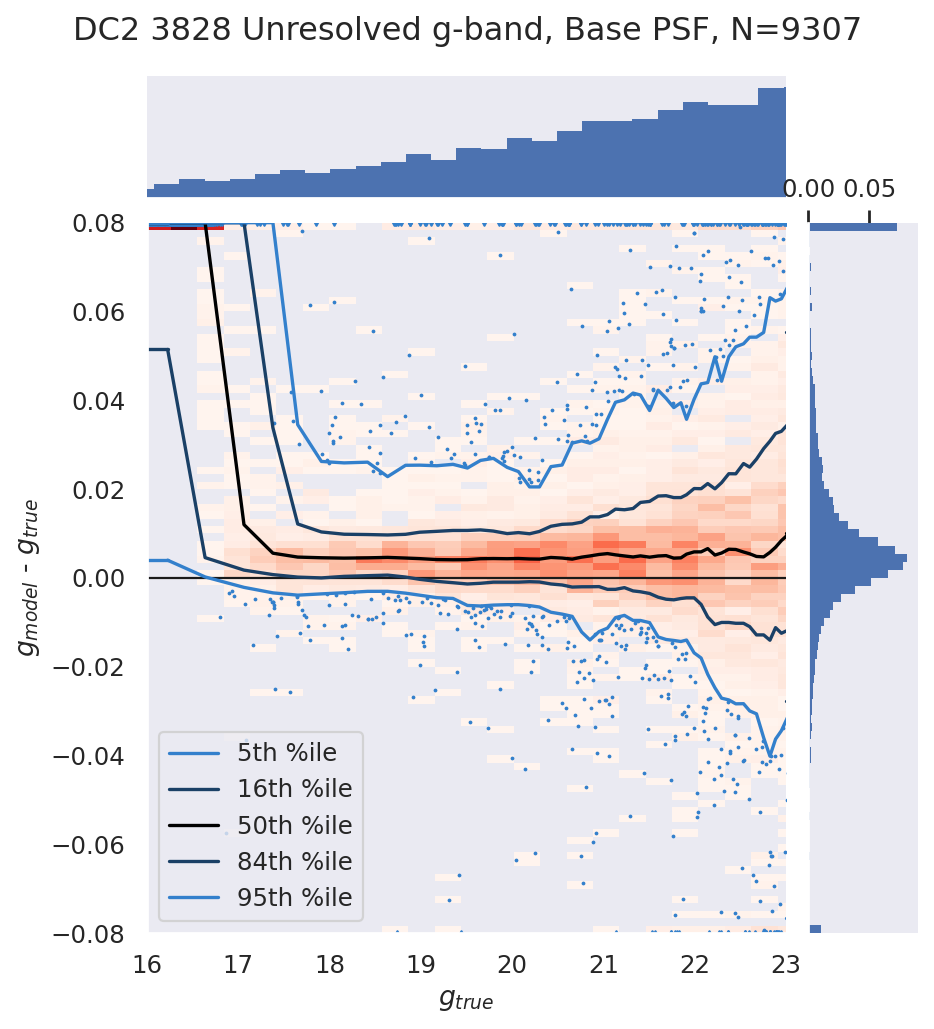

DC2 3828 Unresolved r-band, Base PSF, N=9290


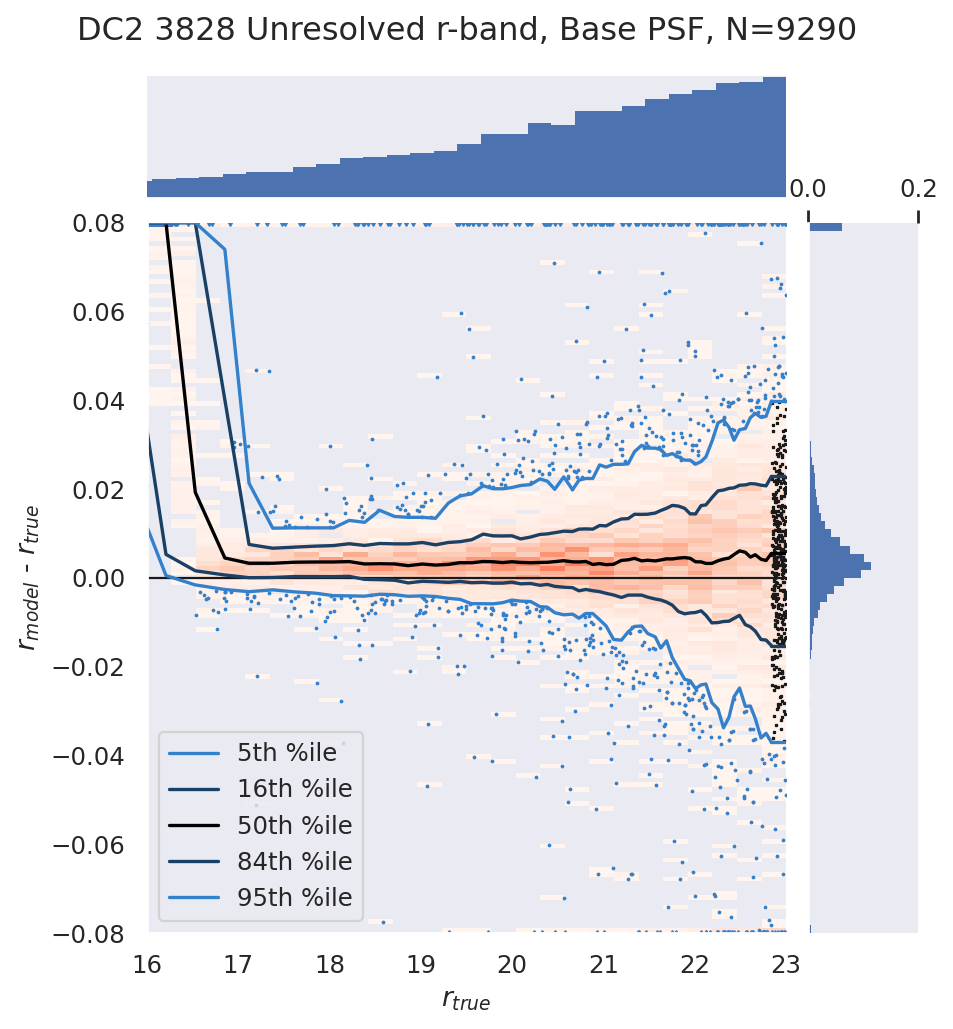

DC2 3828 Unresolved i-band, Base PSF, N=9290


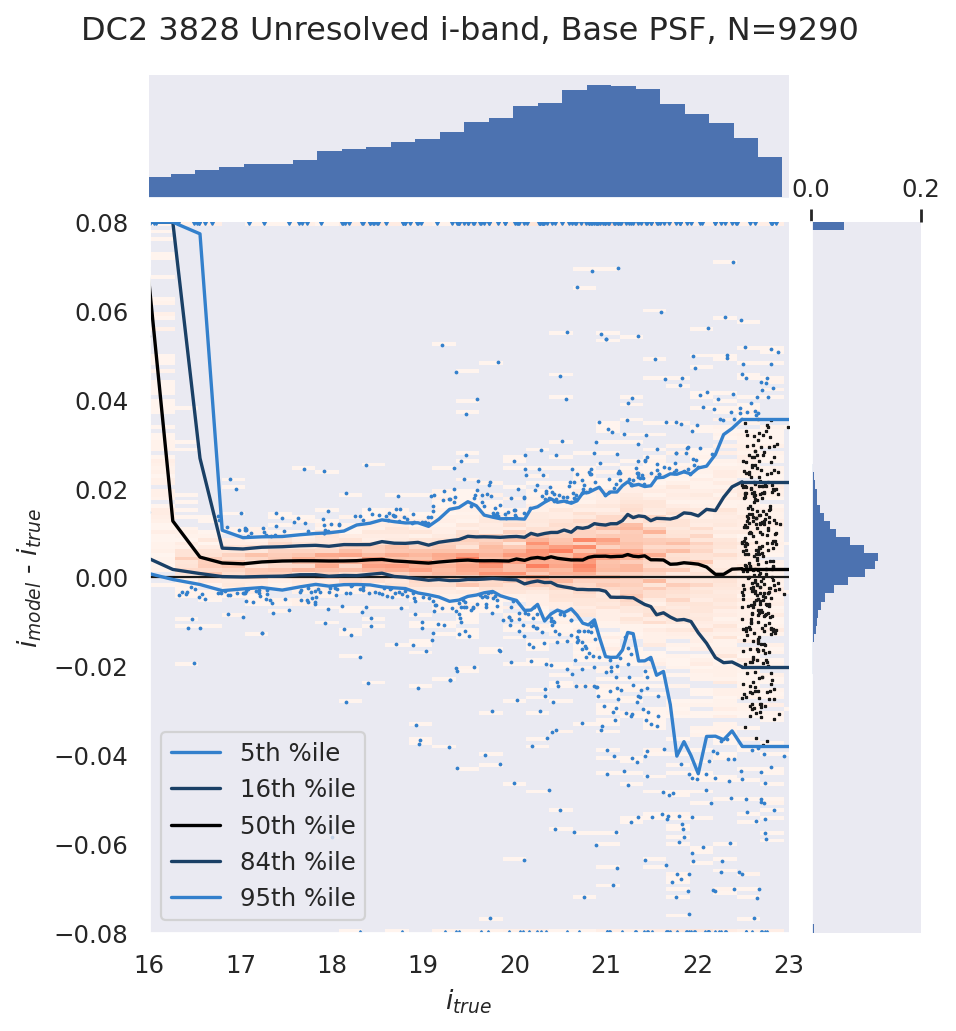

DC2 3828 Unresolved g-r, Base PSF, N=9268


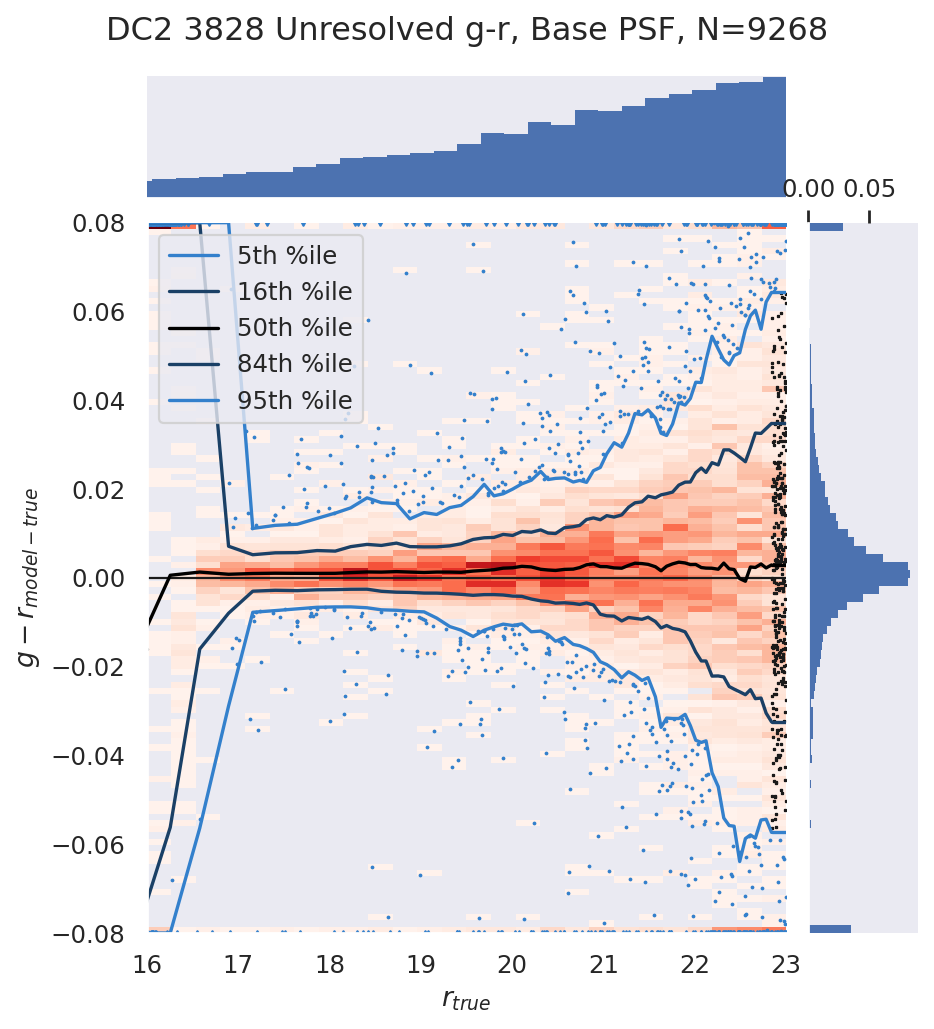

DC2 3828 Unresolved r-i, Base PSF, N=9260


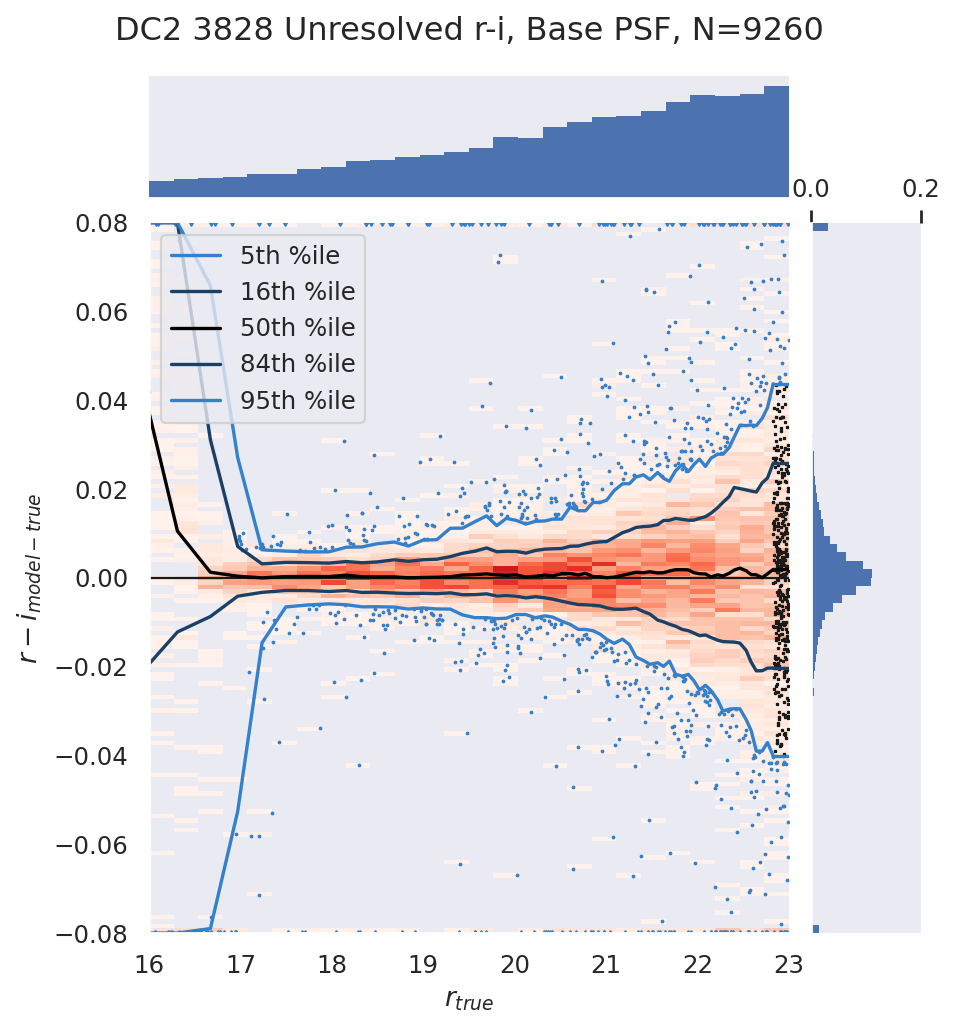

DC2 3828 Unresolved g-band, CModel, N=8820


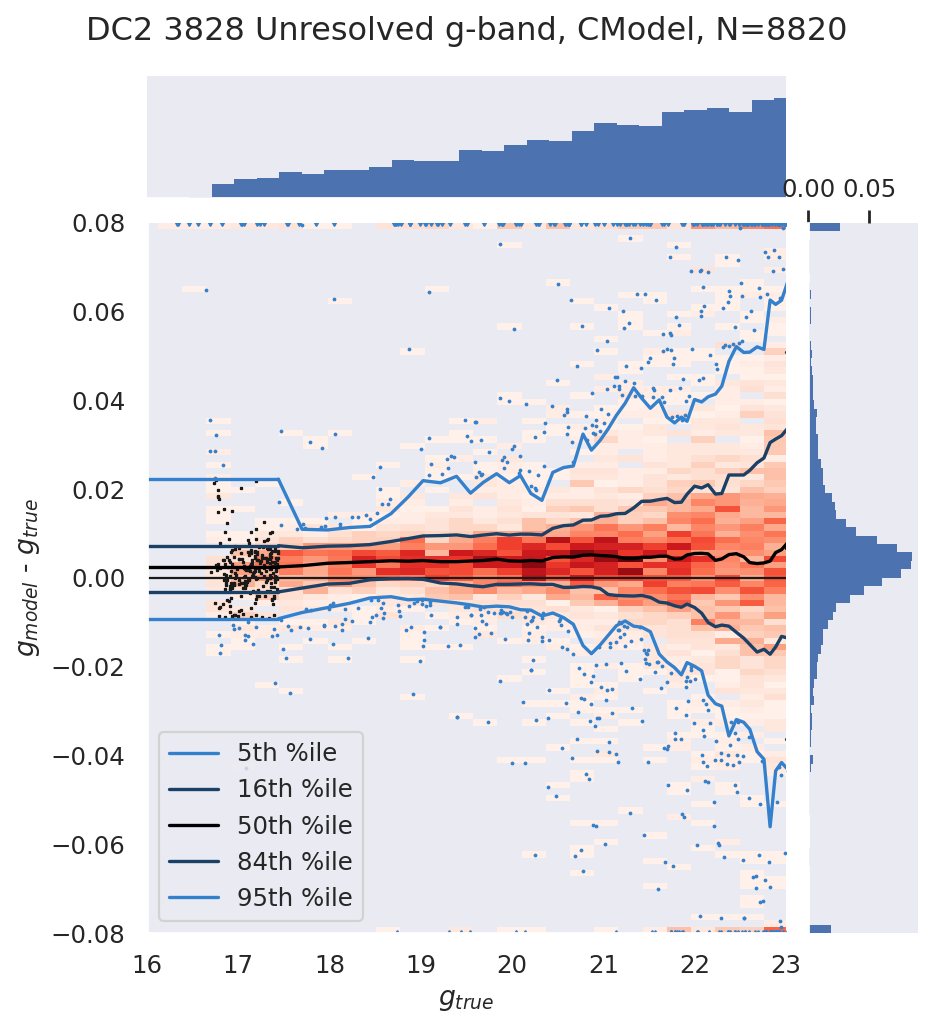

DC2 3828 Unresolved r-band, CModel, N=8756


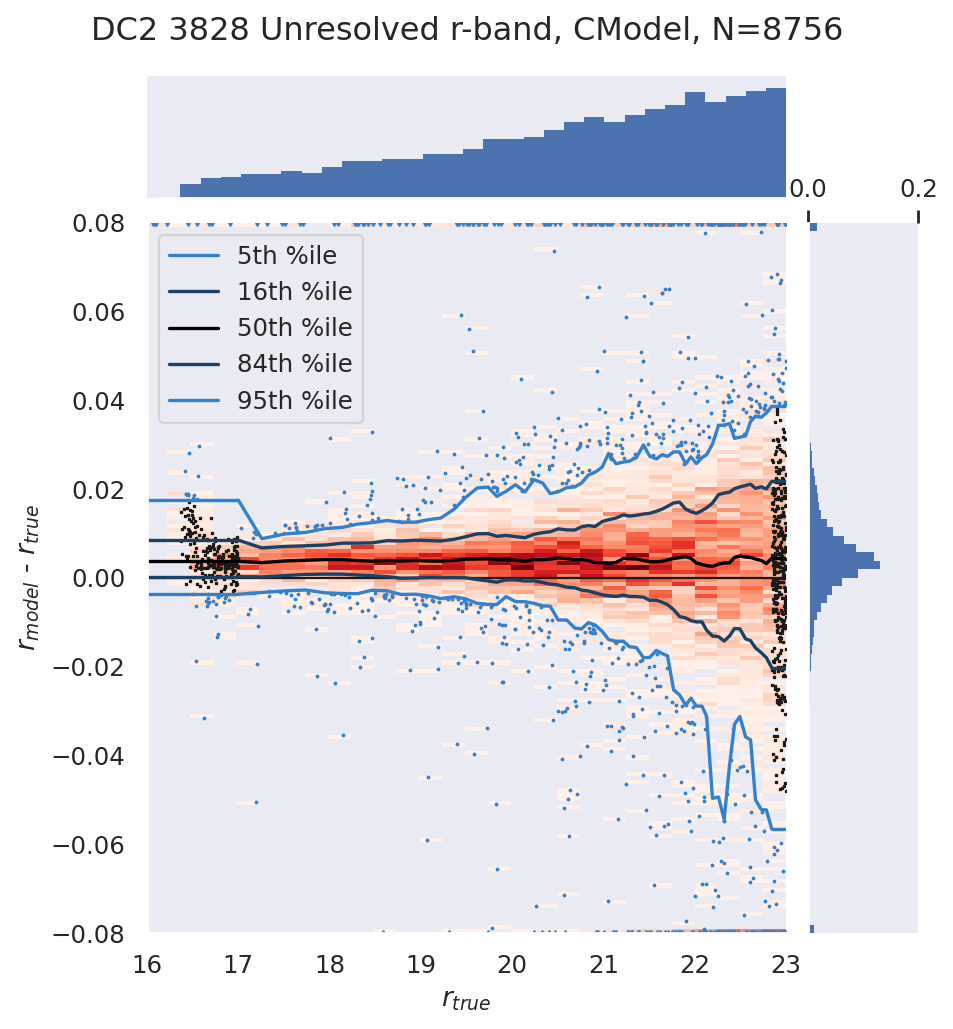

DC2 3828 Unresolved i-band, CModel, N=8777


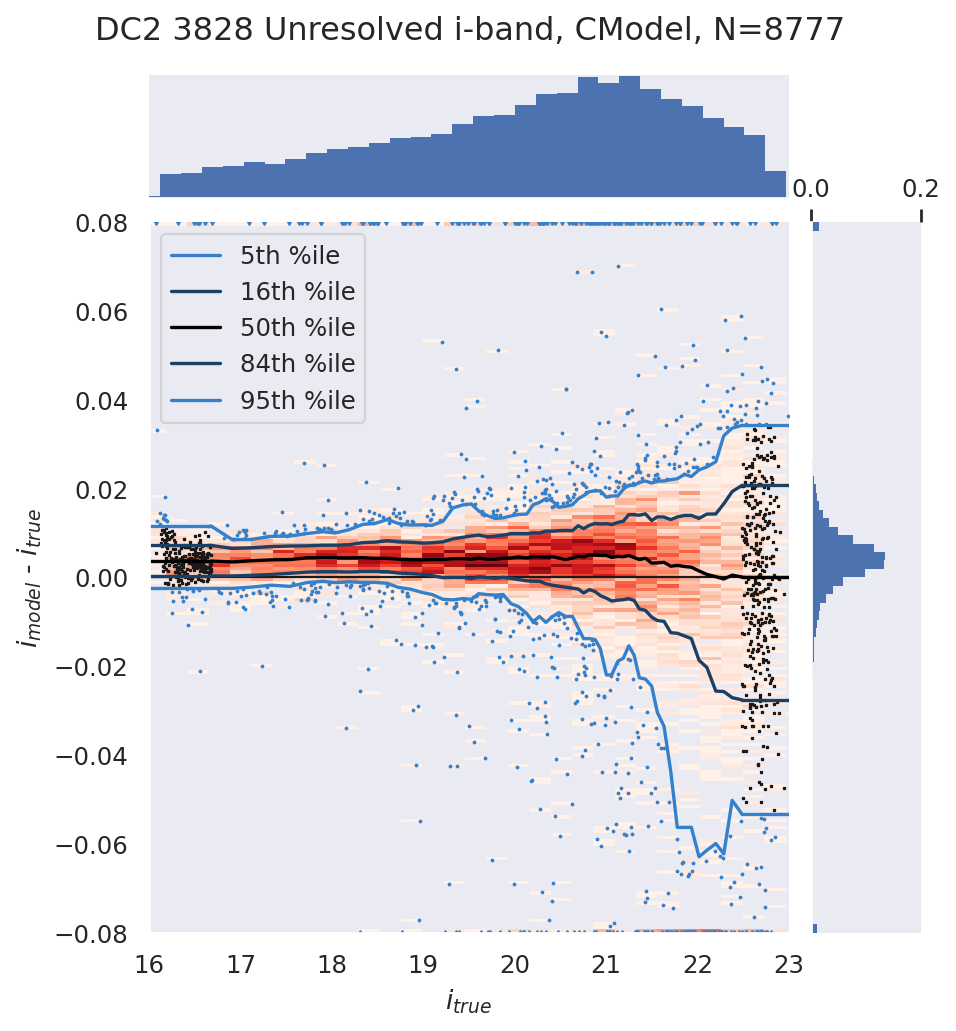

DC2 3828 Unresolved g-r, CModel, N=8722


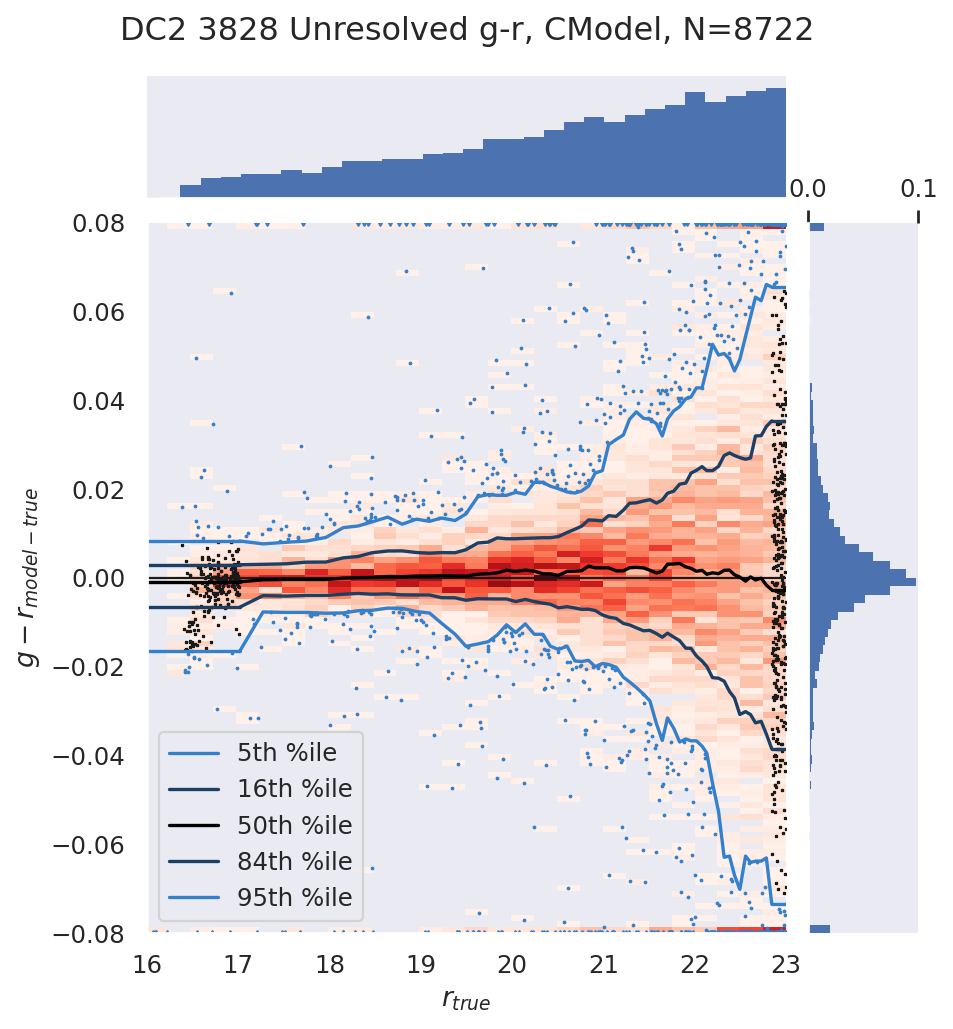

DC2 3828 Unresolved r-i, CModel, N=8702


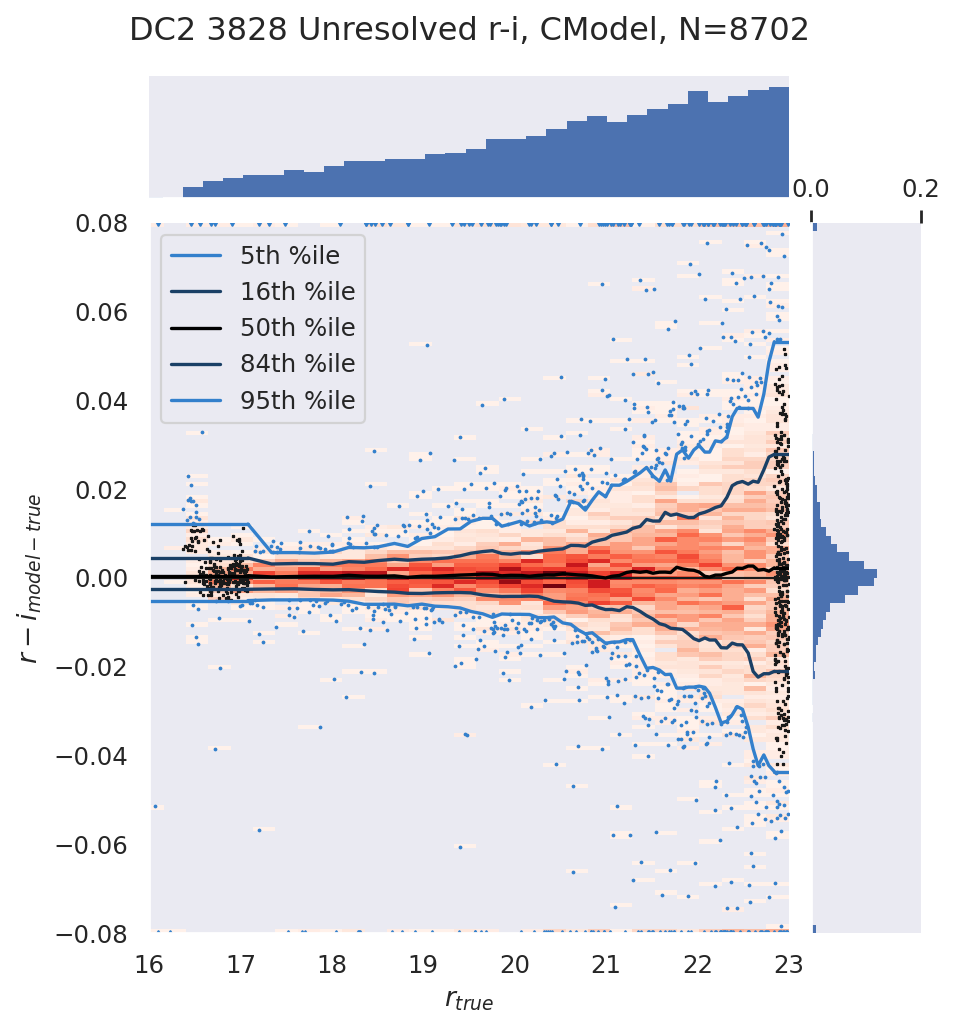

In [8]:
# Plot matches
cats_plot = cats_dc2[name_full]
plot_matches = True
if plot_matches:
    args = dict(scatterleft=True, scatterright=True, densityplot=sns.histplot, cmap='Reds')
    args_types = {
        True: {
            'limx': (14.5, 24.5),
            'limy': (-0.5, 0.5),
        },
        False: {
            'limx': (16, 23),
            'limy': (-0.08, 0.08),
        },
    }
    for resolved, args_type in args_types.items():
        mrPlotMatches.plot_matches(
            cats_plot, resolved, models_meas[f'{name_scarlet}_{name_nr}'],
            filters_single, band_ref=band_ref, band_multi=None,
            band_ref_multi=band_ref, mag_max=24.5, match_dist_asec=0.168,
            plot_compure=False, rematch=True, **args_type, **args
        )

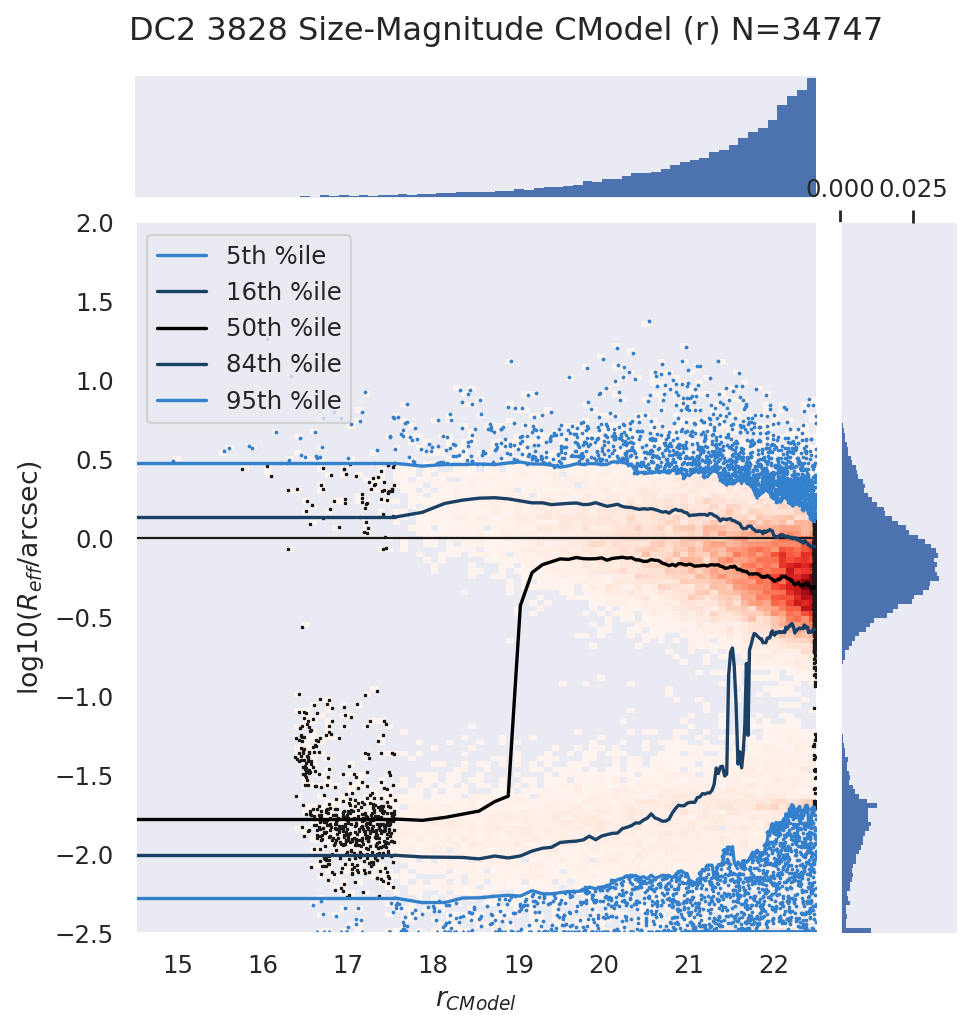

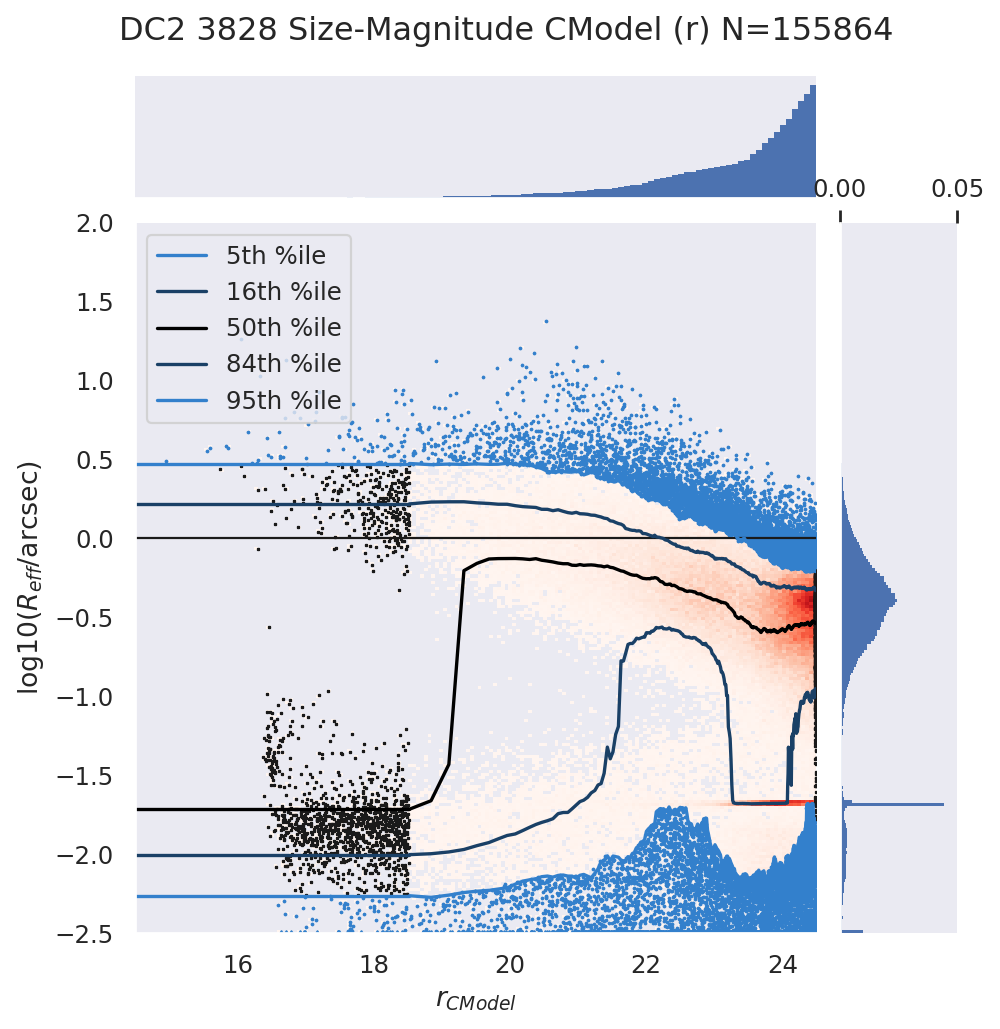

In [9]:
# Measured sizes (no matching)
band = 'r'
cat_plot = cats_plot[3828]['meas'][band]
scale_pix = 0.2
sizes_model = {
    'CModel': np.log10(scale_pix*np.sqrt(0.5*(
        cat_plot['modelfit_CModel_ellipse_xx'] + cat_plot['modelfit_CModel_ellipse_yy'])))
}
mag_min = args_types[True]['limx'][0]

for mag_max in (22.5, 24.5):
    for name_model, sizes in sizes_model.items():
        mag = models_meas[name_full][name_model].get_mag_total(cat_plot, band)
        good = (mag < mag_max) & np.isfinite(sizes)
        plotjoint_running_percentiles(
            mag[good], sizes[good], limx=(mag_min, mag_max), limy=(-2.5, 2),
            labelx=f'${band}_{{{name_model}}}$',
            labely='log10($R_{eff}$/arcsec)',
            title=f'DC2 3828 Size-Magnitude {name_model} ({band_multi if has_multiprofit else band}) N={np.sum(good)}',
            **args,
        )
        plt.show()